# Evaluation of Surrogate Models

Currently we use `RandomForestRegressor(n_estimators=100)` to train a surrogate model mapping hyperparameters to performance.
Before training the performance is normalized s.t. the worst recorded performances on the task is 0, and the best recorded performance is 1.
For each task, we train a separate surrogate model.

A `Problem` object is created, which is a wrapper for a configuration that specifies which hyperparameters to model, and which experiment data or surrogate models to load.

In [143]:
import sys
import pandas as pd
sys.path.append("./src/")
from problem import Problem

problem = Problem("mlr_rpart")

We can now expect the underlying experiment data for the "mlr svm" problem:

In [144]:
problem.data.sample(5)

,task_id,perf.mmce,target,num.impute.selected.cpo,cp,maxdepth,minbucket,minsplit
29388,16.0,0.900500,-2.302585,impute.hist,0.986338,20.0,81.0,61.0
14982,9985.0,0.582543,-1.594246,impute.mean,0.596384,21.0,1.0,71.0
46631,3021.0,0.020683,-0.077467,impute.mean,0.004304,29.0,51.0,32.0
54096,167141.0,0.094400,-0.246943,impute.mean,0.001315,22.0,87.0,7.0
64407,167119.0,0.215467,-0.573575,impute.mean,0.001498,12.0,45.0,57.0


We can also access the metadata for each task (though we don't need it here):

In [145]:
problem.metadata.sample(5)

,m,n,po,p,rc,mcp,mkd,xvar
146821,4,1728,6,21,1.000000,0.700231,0.024390,0.204082
146606,2,98050,28,28,0.000000,0.528577,0.021139,1.000000
9981,9,1080,856,856,0.000000,0.111111,0.000920,1.000000
219,2,45312,8,14,0.500000,0.575455,0.040356,0.566327
29,2,690,15,46,0.869565,0.555072,0.013991,0.287807


In [146]:
# Do we have metadata for all task_ids
problem.metadata.shape[0] == len(problem.data.task_id.unique())

True

And access the surrogate model by task:

In [147]:
problem.surrogates[3893]

RandomForestRegressor(n_jobs=1)

We will evaluate each surrogate model by its rmse, Spearman's $\rho$ and Kendall's $\tau$.
We use 10-fold cross-validation to obtain normalized score predictions for a surrogate model.

In [148]:
from scipy.stats import kendalltau, spearmanr, rankdata
from sklearn.metrics import mean_squared_error
import math

In [149]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

cache = {}

def performance_for_task(problem, task: int, on_training_data=False):
    """ returns surrogate model predicted normalized scores, and normalized observed scores. """
    if not on_training_data and (problem, task) in cache:
        return cache[(problem, task)]
    
    task_experiments = problem.data[problem.data.task_id == task]
    task_configurations = task_experiments[problem.hyperparameters]
    y = task_experiments.target
    normalized_scores = (y - min(y)) / (max(y) - min(y))
    
    if on_training_data:
        surrogate_scores = problem.surrogates[task].predict(task_configurations)
    else:
        surrogate = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        surrogate_scores = cross_val_predict(surrogate, task_configurations, normalized_scores, cv=10)
        cache[(problem, task)] = (surrogate_scores, normalized_scores)
    return surrogate_scores, normalized_scores

In [150]:
def calculate_rank_metrics(y_true, y_hat):
    """ Calculate Spearman's rho and Kendall's tau based on true and predicted model performance.
    
    Assumes that same index in y_true and y_hat represent the same sample.
    
    returns:
        - Spearman's rho
        - two-sided pvalue for rho
        - Kendall's tau
        - two-sided pvalue for tau
    """
    # Calculate orders
    true_order = rankdata(y_true, method='average')
    pred_order = rankdata(y_hat, method='average')
    
    rho, p_rho = spearmanr(true_order, pred_order)
    tau, p_tau = kendalltau(true_order, pred_order)
    return rho, p_rho, tau, p_tau  

In [151]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def distplot(surrogate, actual, ax, bin_zero=False):
    """ Plots the two distributions """
    _ = sns.distplot(surrogate, rug=True, kde=False, label='surrogate', ax=ax)
    _ = sns.distplot(actual, rug=True, kde=False, label='actual', ax=ax)
    _ = ax.set(xlabel='normalized score', ylabel='configurations', title=f'Distribution of Performance')
    # matplotlib inline will display the plot automagically
    
def scatter(df, x_col, y_col, c_col, title, ax, quantile=0.95):
    """ Scatterplot of (x_col, y_col) points, where the specified quantile is colored differently. """
    cut_off = df[c_col].quantile(quantile)
    df = df.assign(top_quantile=lambda r: r[c_col] > cut_off)
    ax = sns.scatterplot(x=x_col, y=y_col, hue="top_quantile", data=df, ax=ax)
    _ = ax.set(
        xscale="log", yscale="log", 
        xlim=(2**-32, 2**32), ylim=(2**-32, 2**32),
        title=title
    )

In [152]:
def score_surrogate(actual, predicted):
    """ Calculate some evaluation metrics for the surrogate model predictions. """
    rho, prho, tau, ptau = calculate_rank_metrics(actual, predicted)
    rmse = math.sqrt(mean_squared_error(actual, predicted))    
    return {
        "rho": rho,
        "prho": prho,
        "tau": tau,
        "ptau": ptau,
        "rmse": rmse,
        "quantile05": (actual - predicted).quantile(0.05),
        "quantile95": (actual - predicted).quantile(0.95)
    }

In [153]:
def incremental_rank_scores(actual, predicted, steps=20):
    rows = []
    for i in range(steps):
        ratio = i/steps
        cutoff = actual.quantile(ratio)
        
        actual_s = actual[actual > cutoff]
        predicted_s = predicted[actual > cutoff]
        rho, _, tau, _ = calculate_rank_metrics(actual_s, predicted_s)
        rows.append({'ratio': 1 - ratio, 'rho': rho, 'tau': tau})
    return rows

def rank_plot(actual, predicted, ax, steps=20):
    rows = incremental_rank_scores(actual, predicted, steps)
    df = pd.DataFrame(rows)
    sns.lineplot(x="ratio", y="rho", data=df, ax=ax, label="rho")
    sns.lineplot(x="ratio", y="tau", data=df, ax=ax, label="tau")
    ax.set(title='rho/tau on top x% of data')
    ax.set(xlabel="% of best configurations included", ylabel="correlation")
        

In [154]:
def plot_task_summary(problem, task):
    predicted, actual = performance_for_task(problem, task)
    
    unfiltered = score_surrogate(actual, predicted)
    scores = pd.DataFrame.from_dict(unfiltered, orient="index", columns=["unfiltered"])
    
    actual_filtered, predicted_filtered = actual[actual > 0], predicted[actual > 0]
    filtered = score_surrogate(actual_filtered, predicted_filtered)
    scores = scores.assign(filtered=filtered.values())
    
    top_10_percent = actual > actual.quantile(0.9)
    actual_10prct, predicted_10prct = actual[top_10_percent], predicted[top_10_percent]
    ten_percent = score_surrogate(actual_10prct, predicted_10prct)
    scores = scores.assign(ten_percent=ten_percent.values())
    
    print(f"Summary for Task {task}")
    print("The following dataframe shows rank metrics for the following subsets of configurations:")
    print(f" - unfiltered: calculated across all configurations ({len(actual)} points)")
    print(f" - filtered: calculated only on those configurations which scored higher than 0 normalized score ({sum(actual > 0)} points)")
    print(f" - filtered: calculated only on the top 10% of configurations ({sum(top_10_percent)} points)")
    with pd.option_context("display.float_format", "{:.4f}".format):
        display(scores.transpose())
        
    task_experiments = problem.data[problem.data.task_id == task]
    task_configurations = task_experiments[problem.hyperparameters]
    df = task_configurations.assign(actual=actual)
    df = df.assign(surrogate=predicted)
    df = df.assign(diff=abs(actual-predicted))
        
    f, axes = plt.subplots(2, 2, figsize=(16, 7))
    # 4x4 plot. 
    # - score distributions
    # - score scatter: best 10% solutions, 10% greatest errors.
    # - same two plots with 0-score solutions left out.
    distplot(predicted, actual, axes[0, 0])
    df_filtered = df[df.actual > 0]
    # scatter(df_filtered, "gamma", "cost", "diff", "Biggest Mistakes Filtered (95%)", axes[1, 0])
    rank_plot(actual, predicted, axes[1, 0])
    scatter(df, "gamma", "cost", "actual", "Best Configurations (95%)", axes[0, 1])
    scatter(df, "gamma", "cost", "diff", "Biggest Mistakes (95%)", axes[1, 1])
    plt.tight_layout()

Summary for Task 3893
The following dataframe shows rank metrics for the following subsets of configurations:
 - unfiltered: calculated across all configurations (984 points)
 - filtered: calculated only on those configurations which scored higher than 0 normalized score (836 points)
 - filtered: calculated only on the top 10% of configurations (99 points)


,rho,prho,tau,ptau,rmse,quantile05,quantile95
unfiltered,0.9828,0.0000,0.9320,0.0000,0.0182,-0.0162,0.0152
filtered,0.9722,0.0000,0.9074,0.0000,0.0195,-0.0180,0.0193
ten_percent,0.7769,0.0000,0.5941,0.0000,0.0205,-0.0104,0.0383


e:\repositories\symbolicdefaults\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
e:\repositories\symbolicdefaults\venv\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
e:\repositories\symbolicdefaults\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
e:\repositories\s

ValueError: Could not interpret value `cost` for parameter `y`

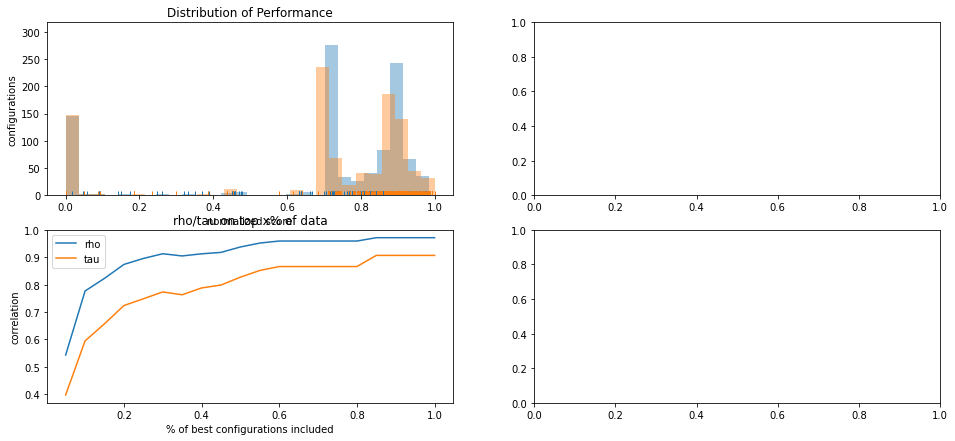

In [155]:
# plot_task_summary(problem, task=3893)

In [20]:
data = df.pivot(index='gamma', columns='cost', values='d_score')
ax = sns.heatmap(data)
#ax.set(xlim=(9.29e-11, 3819), ylim=(8.28e-9, 54085))

NameError: name 'df' is not defined

-----

problem.data

In [156]:
rows = []
for i, task in enumerate(problem.data.task_id.unique()):
    print(f"{i:3d} / {len(problem.data.task_id.unique())}: {task}")
    predicted, actual = performance_for_task(problem, task)
    rows.append(score_surrogate(actual, predicted))

df = pd.DataFrame(rows)
df = df.assign(task=problem.data.task_id.unique())
df.head()

  0 / 115: 3893.0
  1 / 115: 3902.0
  2 / 115: 3903.0
  3 / 115: 3904.0
  4 / 115: 3907.0
  5 / 115: 3913.0
  6 / 115: 3917.0
  7 / 115: 3918.0
  8 / 115: 11.0
  9 / 115: 3945.0
 10 / 115: 12.0
 11 / 115: 14971.0
 12 / 115: 14.0
 13 / 115: 10090.0
 14 / 115: 14965.0
 15 / 115: 10093.0
 16 / 115: 10101.0
 17 / 115: 9981.0
 18 / 115: 9985.0
 19 / 115: 9986.0
 20 / 115: 14970.0
 21 / 115: 9970.0
 22 / 115: 9971.0
 23 / 115: 9976.0
 24 / 115: 9977.0
 25 / 115: 9978.0
 26 / 115: 9952.0
 27 / 115: 9956.0
 28 / 115: 9957.0
 29 / 115: 9960.0
 30 / 115: 15.0
 31 / 115: 9964.0
 32 / 115: 219.0
 33 / 115: 9946.0
 34 / 115: 9950.0
 35 / 115: 7592.0
 36 / 115: 16.0
 37 / 115: 18.0
 38 / 115: 2073.0
 39 / 115: 2074.0
 40 / 115: 2079.0
 41 / 115: 22.0
 42 / 115: 23.0
 43 / 115: 125920.0
 44 / 115: 146606.0
 45 / 115: 167120.0
 46 / 115: 24.0
 47 / 115: 28.0
 48 / 115: 29.0
 49 / 115: 3.0
 50 / 115: 3481.0
 51 / 115: 3022.0
 52 / 115: 31.0
 53 / 115: 3485.0
 54 / 115: 32.0
 55 / 115: 3493.0
 56 / 115:

,rho,prho,tau,ptau,rmse,quantile05,quantile95,task
0,0.982841,0.000000e+00,0.932021,0.000000e+00,0.018163,-0.016171,0.015229,3893.0
1,0.941560,1.200674e-304,0.843348,2.605533e-195,0.046480,-0.015362,0.024855,3902.0
2,0.737684,2.160953e-102,0.652224,3.798521e-87,0.044997,-0.003787,0.011300,3903.0
3,0.904902,5.680790e-266,0.846716,1.319813e-165,0.034488,-0.001826,0.005334,3904.0
4,0.410423,6.170580e-34,0.349240,1.124997e-34,0.049386,-0.017473,0.038710,3907.0


In [157]:
len(df[df.rho < 0.8])

15

In [158]:
all_data = df.set_index('task').join(problem.metadata)

In [159]:
all_data = all_data.join(problem.data.groupby("task_id").target.count().rename('n_experiments'))
all_data = all_data.join(problem.data.groupby("task_id").target.nunique().rename('n_unique_target'))

<AxesSubplot:xlabel='n_experiments', ylabel='n_unique_target'>

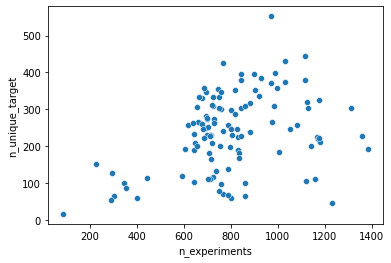

In [160]:
import seaborn as sns
sns.scatterplot(data=all_data, x="n_experiments", y="n_unique_target")

<AxesSubplot:xlabel='n_unique_target', ylabel='rho'>

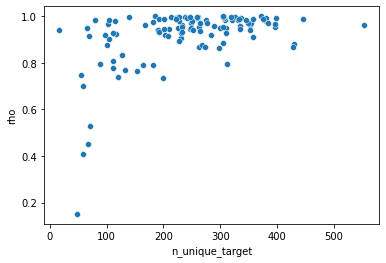

In [161]:
sns.scatterplot(data=all_data, x="n_unique_target", y="rho")

In [162]:
all_data.to_csv("rho_rpart.csv")

In [77]:
df.to
len(df[df.rho < 0.75])

8

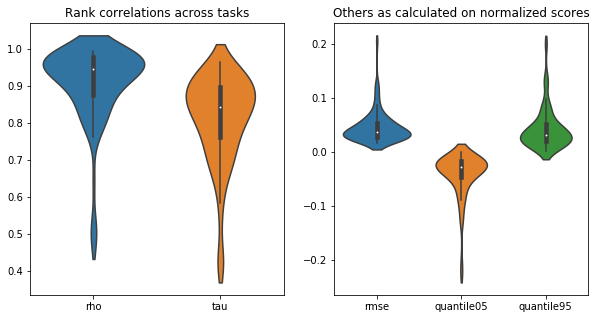

In [30]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
rank_metrics = df[['rho', 'tau']]
ax = sns.violinplot(data=rank_metrics, cut=1.0, ax=axes[0])
_ = ax.set(title='Rank correlations across tasks')

other_metrics = df[['rmse', 'quantile05', 'quantile95']]
ax = sns.violinplot(data=other_metrics, cut=1.0, ax=axes[1])
_ = ax.set(title='Others as calculated on normalized scores')

In [31]:
rows = []
for task in problem.data.task_id.unique():
    predicted, actual = performance_for_task(problem, task)
    inc_scores = incremental_rank_scores(actual, predicted)
    for score in inc_scores:
        score['task'] = task
    rows += inc_scores
    
df = pd.DataFrame(rows)

/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/flo/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/flo/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/flo/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


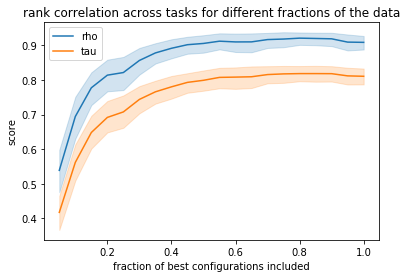

In [32]:
ax = sns.lineplot(x="ratio", y="rho", data=df, label="rho")
ax = sns.lineplot(x="ratio", y="tau", data=df, label="tau")
_ = ax.set(
    title="rank correlation across tasks for different fractions of the data",
    ylabel="score",
    xlabel="fraction of best configurations included"
)

----

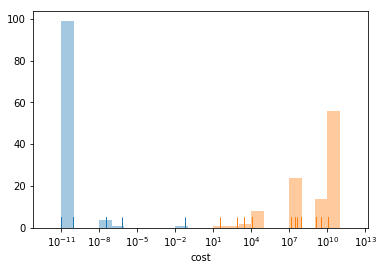

In [33]:
import numpy as np
bins = list(np.logspace(-12, 12, 25))
ax = sns.distplot(problem.data.groupby(by='task_id').min().cost, kde=False, rug=True, bins=bins, label='min')
ax = sns.distplot(problem.data.groupby(by='task_id').max().cost, kde=False, rug=True, bins=bins, label='max')
ax.set_xscale("log")

In [34]:
problem.data.groupby(by='task_id').min().cost

task_id
3.0         1.008280e-11
6.0         9.296000e-11
11.0        1.008280e-11
12.0        1.008280e-11
14.0        1.008280e-11
15.0        1.008280e-11
16.0        1.008280e-11
18.0        1.008280e-11
22.0        1.008280e-11
23.0        1.008280e-11
24.0        9.296000e-11
28.0        9.296000e-11
29.0        1.008280e-11
31.0        1.008280e-11
32.0        9.296000e-11
37.0        1.008280e-11
41.0        1.008280e-11
43.0        9.296000e-11
45.0        9.296000e-11
49.0        1.008280e-11
53.0        1.008280e-11
58.0        9.296000e-11
219.0       3.546570e-08
2073.0      1.008280e-11
2074.0      9.296000e-11
2079.0      1.008280e-11
3021.0      1.008280e-11
3022.0      1.008280e-11
3481.0      9.296000e-11
3485.0      1.008280e-11
                ...     
145681.0    1.008280e-11
146195.0    3.546570e-08
146212.0    9.296000e-11
146607.0    9.296000e-11
146800.0    1.008280e-11
146817.0    1.008280e-11
146818.0    1.008280e-11
146819.0    1.008280e-11
146820.0    1.008

In [57]:
problem.data.cost.quantile([x / 10 for x in range(10)])

0.0    1.209920e-15
0.1    8.321520e-04
0.2    5.101060e-03
0.3    2.997650e-02
0.4    1.689480e-01
0.5    9.959230e-01
0.6    5.176180e+00
0.7    2.953510e+01
0.8    1.663260e+02
0.9    9.931350e+02
Name: cost, dtype: float64

In [4]:
import itertools
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

min_c = problem.data.groupby(by='task_id')

costs = np.geomspace(problem.data.cost.min(), problem.data.cost.max(), 200)
gammas = np.geomspace(problem.data.gamma.min(), problem.data.gamma.max(), 200)

configurations = list(itertools.product(costs, gammas))

/home/flo/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/flo/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/flo/.local/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.22.2.post1. This mi

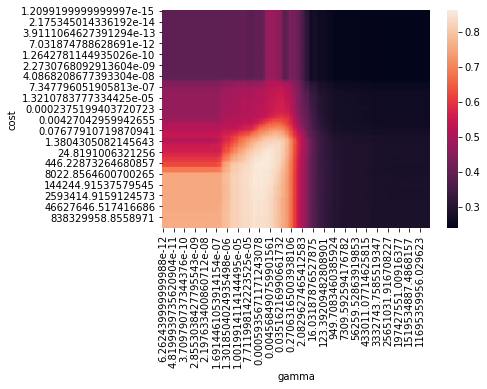

In [5]:
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])
for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

max: 0.8593530103624727


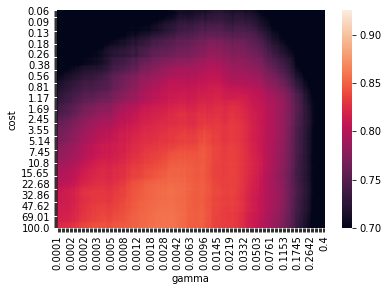

In [6]:
# Zoomed in:
costs = np.geomspace(6e-2, 100, 201)
gammas = np.geomspace(1e-4, 0.4, 201)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)
print(f"max: {surrogate_scores['mean'].max()}")

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
g = sns.heatmap(surrogate_pivot, vmin=0.7, vmax=0.925,
                xticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.columns.values.round(4))],
                yticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.index.values.round(2))])
plt.savefig("figures/svm_response.png", bbox_inches='tight', pad_inches=.1)

max: 0.90387935682708


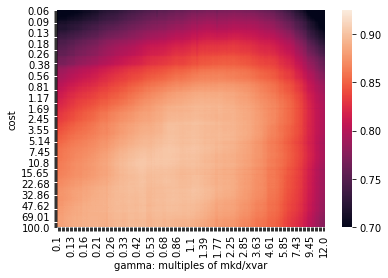

In [13]:
# Warp with metafeatures m, mkd
costs =  np.geomspace(6e-2, 100, 201)
gammas = np.geomspace(1e-1, 12, 201)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs, gammas * problem.metadata.loc[task,"mkd"] / problem.metadata.loc[task,"xvar"]))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)
print(f"max: {surrogate_scores['mean'].max()}")
surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
g = sns.heatmap(surrogate_pivot, 
                vmin=0.7, vmax=0.925,
                xticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.columns.values.round(2))],
                yticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.index.values.round(2))])
g.set(xlabel='gamma: multiples of mkd/xvar')
plt.savefig("figures/svm_response_mkd.png", bbox_inches='tight', pad_inches=.1)
plt.show(g)

max: 0.8603079718518517


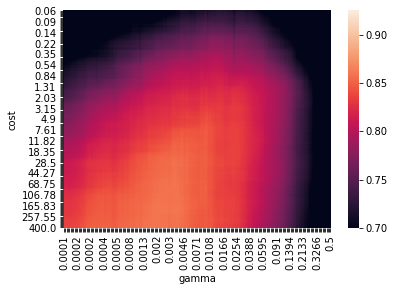

In [15]:
# LARGE
costs = np.geomspace(6e-2, 400, 201)
gammas = np.geomspace(1e-4, 0.4, 201)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)
print(f"max: {surrogate_scores['mean'].max()}")

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
g = sns.heatmap(surrogate_pivot, vmin=0.7, vmax=0.925,
                xticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.columns.values.round(4))],
                yticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.index.values.round(2))])
plt.savefig("figures/svm_response_large.png", bbox_inches='tight', pad_inches=.1)

In [110]:
a = problem.metadata["mkd"] / problem.metadata["xvar"]
min(a), np.mean(a), max(a)

(4.796345483828062e-05, 0.05966737628835906, 0.5491481524447247)

In [91]:
problem.data.task_id.unique()

array([3.89300e+03, 3.90200e+03, 3.90300e+03, 3.90400e+03, 3.90700e+03,
       3.91300e+03, 3.91700e+03, 3.91800e+03, 1.10000e+01, 3.94500e+03,
       1.20000e+01, 1.49710e+04, 1.40000e+01, 1.00900e+04, 1.49650e+04,
       1.00930e+04, 1.01010e+04, 9.98100e+03, 9.98500e+03, 9.98600e+03,
       1.49700e+04, 9.97000e+03, 9.97100e+03, 9.97600e+03, 9.97700e+03,
       9.97800e+03, 9.95200e+03, 9.95600e+03, 9.95700e+03, 9.96000e+03,
       1.50000e+01, 9.96400e+03, 2.19000e+02, 9.94600e+03, 9.95000e+03,
       7.59200e+03, 1.60000e+01, 1.80000e+01, 2.07300e+03, 2.07400e+03,
       2.07900e+03, 2.20000e+01, 2.30000e+01, 1.25920e+05, 2.40000e+01,
       2.80000e+01, 2.90000e+01, 3.00000e+00, 3.48100e+03, 3.02200e+03,
       3.10000e+01, 3.48500e+03, 3.20000e+01, 3.49300e+03, 3.70000e+01,
       3.51000e+03, 3.51200e+03, 3.02100e+03, 1.25921e+05, 1.45681e+05,
       1.25922e+05, 1.46607e+05, 1.46195e+05, 1.67140e+05, 1.46212e+05,
       1.67141e+05, 1.67211e+05, 1.46800e+05, 1.46821e+05, 1.671

0.9899990564880599


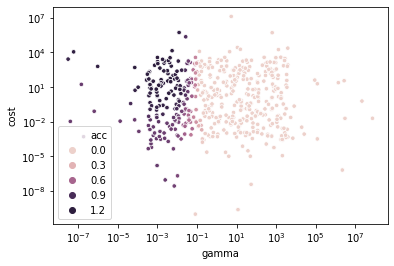

0.9037786677620319


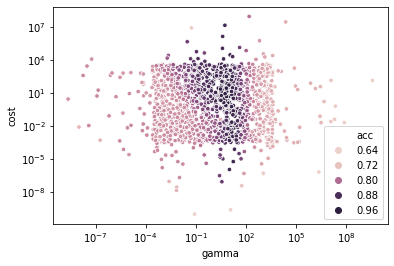

0.9898576512455516


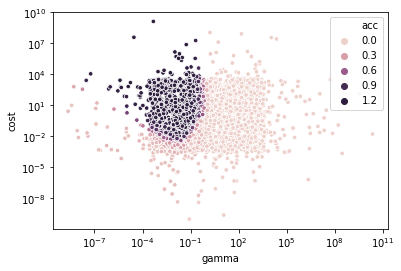

In [96]:
import random
for task in random.sample(list(problem.data.task_id.unique()), 3):
    surrogate_pivot = surrogate_scores.pivot("cost", "gamma", task)
    # g = sns.heatmap(surrogate_pivot, vmin=0.1, vmax=0.95)
    pdf = problem.data[problem.data.kernel == "radial"]
    pdf = pdf[pdf.task_id == task]
    pdf["acc"] = 1 + pdf["target"]
    print(pdf["acc"].max())
    p = sns.scatterplot(data=pdf, x="gamma", y="cost",s=20, hue="acc", vmax=1.0)
    p.set_yscale("log")
    p.set_xscale("log")
    plt.show()

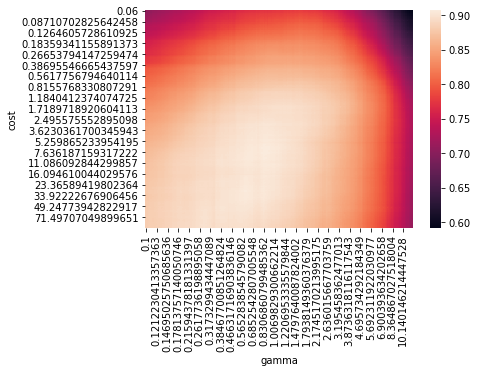

In [19]:
# Warp with metafeatures 1 / (p*xvar)
costs =  np.geomspace(6e-2, 100, 200)
gammas = np.geomspace(1e-1, 12, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])


for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs, gammas * (1 / problem.metadata.loc[task,"p"] / problem.metadata.loc[task,"xvar"])))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

### Standard Deviation

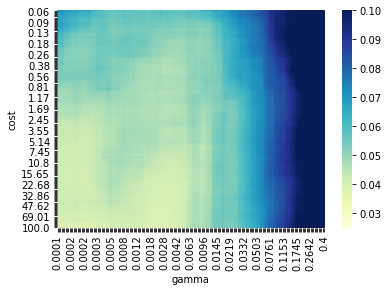

In [124]:
# Zoomed in:
costs = np.geomspace(6e-2, 100, 201)
gammas = np.geomspace(1e-4, 0.4, 201)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].apply(np.var, axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
g = sns.heatmap(surrogate_pivot, vmin = 0.025, vmax = 0.1, cmap="YlGnBu",
                xticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.columns.values.round(4))],
                yticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.index.values.round(2))])

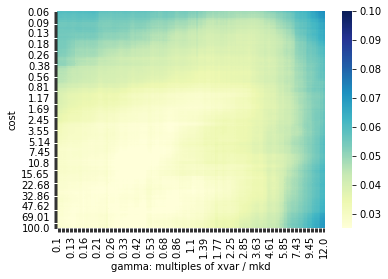

In [123]:
# Warp with metafeatures m, mkd
costs =  np.geomspace(6e-2, 100, 201)
gammas = np.geomspace(1e-1, 12, 201)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs, gammas * problem.metadata.loc[task,"mkd"] / problem.metadata.loc[task,"xvar"]))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].apply(np.var, axis=1)
surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
g = sns.heatmap(surrogate_pivot,vmin = 0.025, vmax = 0.1, cmap="YlGnBu",
                xticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.columns.values.round(2))],
                yticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.index.values.round(2))])
g.set(xlabel='gamma: multiples of xvar / mkd')
plt.show(g)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z = surrogate_pivot.values
x, y = surrogate_scores["gamma"].values, surrogate_scores["cost"].values
x = [[x] for x in range(len(x))]
y = [[y] for x in range(len(y))]
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.show()

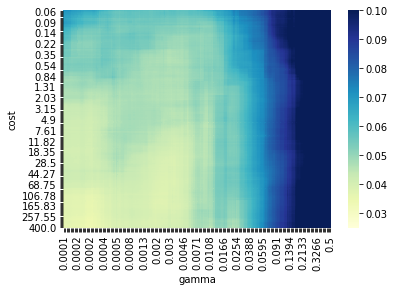

In [16]:
costs = np.geomspace(6e-2, 400, 201)
gammas = np.geomspace(1e-4, 0.5, 201)

configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].apply(np.var, axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
g = sns.heatmap(surrogate_pivot, vmin = 0.025, vmax = 0.1, cmap="YlGnBu",
                xticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.columns.values.round(4))],
                yticklabels=[x if i % 10 == 0 else None for i, x in enumerate(surrogate_pivot.index.values.round(2))])
plt.savefig("figures/svm_sd_large.png", bbox_inches='tight', pad_inches=.1)

In [19]:
len(problem.surrogates)

106

## Clustering Datasets
Datasets have different response surfaces. Can we detect clusters?

In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [138]:
df = surrogate_scores.iloc[:,2:-1]
X = df.T.values
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=2000)
tsne_results = tsne.fit_transform(X)
tsnedf = pd.DataFrame(tsne_results)
tsnedf.columns = ["0", "1"]
tsnedf['task'] = df.columns

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 106 samples in 0.027s...
[t-SNE] Computed neighbors for 106 samples in 0.750s...
[t-SNE] Computed conditional probabilities for sample 106 / 106
[t-SNE] Mean sigma: 6.960813
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.177193
[t-SNE] KL divergence after 700 iterations: 0.780621


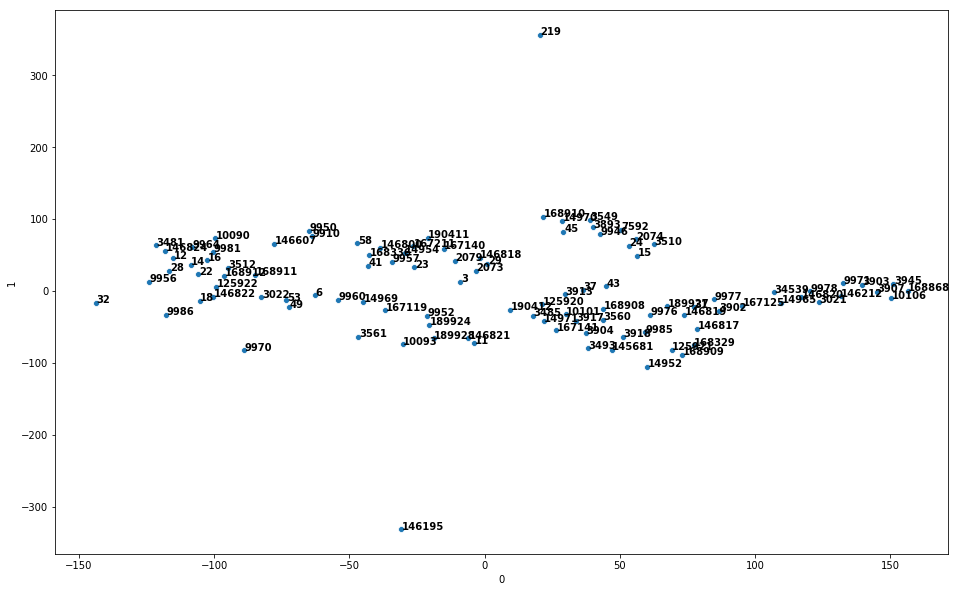

In [139]:
plt.figure(figsize=(16,10))
p=sns.scatterplot(
    x="0", y="1",
    data=tsnedf,
    legend="full"
)

for line in range(106):
     p.text(tsnedf['0'][line]+0.2, tsnedf['1'][line], tsnedf.task[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

In [ ]:
# List of settings:
d0 = surrogate_scores.loc[surrogate_scores["mean"] == max(surrogate_scores["mean"])]
best_idx = 0
best = 0
for idx, row in surrogate_scores.iterrows():
    newmax = np.mean(np.maximum(row.iloc[2:-1].values, d0.iloc[:,2:-1].values))
    if (newmax > best):
        print(f"Newmax found: {newmax}")
        best = newmax
        best_idx = idx

surrogate_scores.iloc[best_idx,:]